# Variational Autoencoders

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Set seeds
np.random.seed(10)
tf.random.set_seed(10)

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D

from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import mse, binary_crossentropy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns
import re
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import matplotlib.ticker as mtick

/home/rmlans/anaconda3/envs/tf2_env/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


### Grab data from Github (for Colab)

In [3]:
!wget -O train.npy https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/AE_and_GAN/Science_Data/train.npy?raw=true
!wget -O validation.npy https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/AE_and_GAN/Science_Data/validation.npy?raw=true
!wget -O SWE_VAE_Weights.h5 https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/AE_and_GAN/saved_models/SWE_VAE_Weights.h5?raw=true

--2020-08-06 21:57:30--  https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/AE_and_GAN/Science_Data/train.npy?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/argonne-lcf/ATPESC_MachineLearning/raw/master/AE_and_GAN/Science_Data/train.npy [following]
--2020-08-06 21:57:30--  https://github.com/argonne-lcf/ATPESC_MachineLearning/raw/master/AE_and_GAN/Science_Data/train.npy
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/argonne-lcf/ATPESC_MachineLearning/master/AE_and_GAN/Science_Data/train.npy [following]
--2020-08-06 21:57:30--  https://raw.githubusercontent.com/argonne-lcf/ATPESC_MachineLearning/master/AE_and_GAN/Science_Data/train.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.76.133
Conne

### Load Data

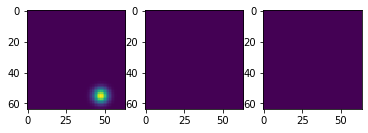

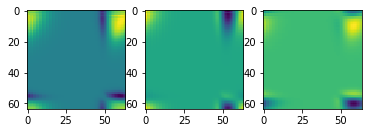

In [2]:
swe_data = np.transpose(np.load('./train.npy'))
swe_data_v = np.transpose(np.load('./validation.npy'))

swe_train_data = np.zeros(shape=(400,64,64,3)) # Channels last
swe_valid_data = np.zeros(shape=(400,64,64,3)) # Channels last

for i in range(np.shape(swe_data)[0]):
    temp_1 = swe_data[i,0:64*64].reshape(64,64)
    temp_2 = swe_data[i,64*64:2*64*64].reshape(64,64)
    temp_3 = swe_data[i,2*64*64:3*64*64].reshape(64,64)
    swe_train_data[i,:,:,0] = np.transpose(temp_1[:,:])
    swe_train_data[i,:,:,1] = np.transpose(temp_2[:,:])
    swe_train_data[i,:,:,2] = np.transpose(temp_3[:,:])
    
for i in range(np.shape(swe_data)[0]):
    temp_1 = swe_data_v[i,0:64*64].reshape(64,64)
    temp_2 = swe_data_v[i,64*64:2*64*64].reshape(64,64)
    temp_3 = swe_data_v[i,2*64*64:3*64*64].reshape(64,64)
    swe_valid_data[i,:,:,0] = np.transpose(temp_1[:,:])
    swe_valid_data[i,:,:,1] = np.transpose(temp_2[:,:])
    swe_valid_data[i,:,:,2] = np.transpose(temp_3[:,:])
    

# Just to keep things simple
swe_train_data = swe_train_data[0:200,:,:,:]
swe_valid_data = swe_valid_data[0:200,:,:,:]

for j in range(3):
    swe_train_data[:,:,:,j] = (swe_train_data[:,:,:,j] - np.min(swe_train_data[:,:,:,0]))/(np.max(swe_train_data[:,:,:,0])-np.min(swe_train_data[:,:,:,0]))
    swe_valid_data[:,:,:,j] = (swe_valid_data[:,:,:,j] - np.min(swe_valid_data[:,:,:,0]))/(np.max(swe_valid_data[:,:,:,0])-np.min(swe_valid_data[:,:,:,0]))

# Visualize one time instance
time = 0
fig, ax = plt.subplots(nrows=1,ncols=3)

ax[0].imshow(swe_train_data[time,:,:,0])
ax[1].imshow(swe_train_data[time,:,:,1])
ax[2].imshow(swe_train_data[time,:,:,2])
plt.show()


# Visualize one time instance
time = 20
fig, ax = plt.subplots(nrows=1,ncols=3)

ax[0].imshow(swe_valid_data[time,:,:,0])
ax[1].imshow(swe_valid_data[time,:,:,1])
ax[2].imshow(swe_valid_data[time,:,:,2])
plt.show()

### ML Presets and Custom Functions

In [3]:
mode = 'test'
lrate = 0.0001

latent_dim = 2*2*2
epsilon_mean = 0.1
epsilon_std = 1e-4

def mean_absolute_error(y_pred,y_true):
    return K.mean(K.abs(y_true-y_pred))

def max_absolute_error(y_pred,y_true):
    return K.max(K.abs(y_true-y_pred))

# reparameterization trick for VAE
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
     Arguments
        args (tensor): mean and log of variance of Q(z|X)
     Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim), mean=epsilon_mean, stddev=epsilon_std)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [4]:
# Define recursive model architecture
weights_filepath = './SWE_VAE_Weights.h5'
# Encoder    
encoder_inputs = Input(shape=(64,64,3),name='Field')
# Encode   
x = Conv2D(30,kernel_size=(3,3),activation='relu',padding='same')(encoder_inputs)
enc_l2 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(25,kernel_size=(3,3),activation='relu',padding='same')(enc_l2)
enc_l3 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(20,kernel_size=(3,3),activation='relu',padding='same')(enc_l3)
enc_l4 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(15,kernel_size=(3,3),activation='relu',padding='same')(enc_l4)
enc_l5 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(2,kernel_size=(3,3),activation=None,padding='same')(enc_l5)
encoded = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation=None)(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs=encoder_inputs, outputs=z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Field (InputLayer)              [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 30)   840         Field[0][0]                      
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 30)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 25)   6775        max_pooling2d[0][0]              
____________________________________________________________________________________________

In [5]:
# Build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(16, activation='relu')(latent_inputs)
x = Dense(32, activation='relu')(x)
x = Dense(2*2*2, activation=None)(x)
x = Reshape((2, 2, 2))(x)
   
x = Conv2D(2,kernel_size=(3,3),activation=None,padding='same')(x)
dec_l1 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(15,kernel_size=(3,3),activation='relu',padding='same')(dec_l1)
dec_l2 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(20,kernel_size=(3,3),activation='relu',padding='same')(dec_l2)
dec_l3 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(25,kernel_size=(3,3),activation='relu',padding='same')(dec_l3)
dec_l4 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(30,kernel_size=(3,3),activation='relu',padding='same')(dec_l4)
dec_l5 = UpSampling2D(size=(2, 2))(x)

decoded = Conv2D(3,kernel_size=(3,3),activation=None,padding='same')(dec_l5)
decoder = Model(inputs=latent_inputs,outputs=decoded)

decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 8)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 2)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 2)           38        
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 4, 4, 2)           0     

In [6]:
# instantiate VAE model
outputs = decoder(encoder(encoder_inputs))
model = Model(inputs=encoder_inputs,outputs=outputs, name='VAE')

In [7]:
# Calculate custom loss in separate function
reconstruction_loss = binary_crossentropy(K.flatten(encoder_inputs), K.flatten(outputs))
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
vae_loss = K.mean(reconstruction_loss - 0.5*kl_loss)
model.add_loss(vae_loss)

In [8]:
num_epochs = 5000
batch_size = 4

# design network
my_adam = optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

checkpoint = ModelCheckpoint(weights_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint]

model.compile(optimizer=my_adam,metrics=[mean_absolute_error,max_absolute_error])
model.summary()

if mode == 'train':
    # train the autoencoder
    model.fit(x=swe_train_data,y=swe_train_data,epochs=num_epochs, batch_size=batch_size, validation_split=0.1, callbacks=callbacks_list)
    model.save_weights(weights_filepath)

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Field (InputLayer)              [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 8)            16978       Field[0][0]                      
__________________________________________________________________________________________________
model (Model)                   (None, 64, 64, 3)    16113       encoder[1][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 30)   840         Field[0][0]                      
________________________________________________________________________________________________

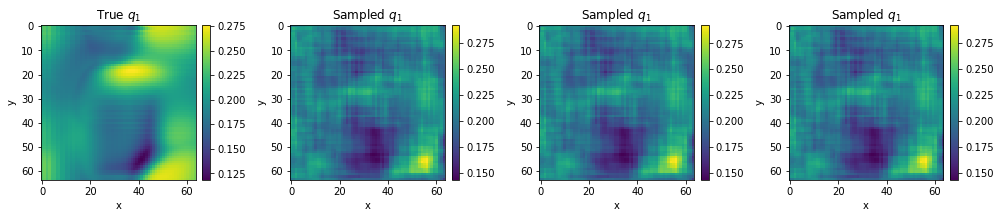

In [9]:
# Check for validation
time = 100

model.load_weights(weights_filepath)
from scipy.ndimage import gaussian_filter
recoded_1 = np.copy(model.predict(swe_train_data[time:time+1,:,:,:]))
recoded_2 = np.copy(model.predict(swe_train_data[time:time+1,:,:,:]))
recoded_3 = np.copy(model.predict(swe_train_data[time:time+1,:,:,:]))

fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(14,12))

cs1 = ax[0].imshow(swe_train_data[time,:,:,0],label='input')
cs2 = ax[1].imshow(recoded_1[0,:,:,0],label='decoded 1')
cs3 = ax[2].imshow(recoded_2[0,:,:,0],label='decoded 2')
cs4 = ax[3].imshow(recoded_3[0,:,:,0],label='decoded 3')

for i in range(4):
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
        
fig.colorbar(cs1,ax=ax[0],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[2],fraction=0.046, pad=0.04)
fig.colorbar(cs4,ax=ax[3],fraction=0.046, pad=0.04)

ax[0].set_title(r'True $q_1$')
ax[1].set_title(r'Sampled $q_1$')
ax[2].set_title(r'Sampled $q_1$')
ax[3].set_title(r'Sampled $q_1$')

plt.tight_layout()
plt.show()

### Individual reconstructions are slightly different (connect to aleatoric uncertainty)

In [10]:
recoded_1 == recoded_2

array([[[[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],

        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],

        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],

        ...,

        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],

        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [Fa